In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

mobility_df = pd.read_csv('erasmus_data_clean.csv', sep=';',low_memory=False, header=0)
for i, name in enumerate(mobility_df.columns):
    print(i, name)

0 Sending Organization
1 Receiving Organization
2 Participants
3 Field of Education
4 Sending Country Code
5 Receiving Country Code


In [2]:
# mobility_df = df[df[df.columns[10]]=='Learner']
# mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
# mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# # consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# # i numeri cambiano parecchio di anno in anno, è normale?
# #mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
# mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 14, 6))]]
# print((mobility_df['Field of Education'].nunique())) 
# mobility_df['Sending Organization'] = mobility_df['Sending Organization'].str.upper()
# mobility_df['Receiving Organization'] = mobility_df['Receiving Organization'].str.upper()

141


In [2]:
display(mobility_df)

,Sending Organization,Receiving Organization,Participants,Field of Education,Sending Country Code,Receiving Country Code
0,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,music and performing arts,AT,SE
1,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,environmental protection technology,UA,AT
2,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,electronics and automation,UA,AT
3,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,mechanics and metal trades,UA,AT
4,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,mining and extraction,AT,RU
...,...,...,...,...,...,...
234603,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,political sciences and civics,UK,RU
234604,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,political sciences and civics,UK,RU
234605,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,UNIVERSITY COLLEGE LONDON,1,economics,RU,UK
234606,UNIVERSITY COLLEGE LONDON,THE HEBREW UNIVERSITY OF JERUSALEM,1,arts and humanities,UK,IL


In [4]:
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not further defined','')
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', inter-disciplinary programmes','')
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classified','')
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(' not elsewhere classified','')
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace(', not elsewhere classifed','')
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.replace('Inter-disciplinary programmes and qualifications involving ','')
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.lower()
# mobility_df['Field of Education'] = mobility_df['Field of Education'].str.strip()

In [3]:
print(mobility_df['Field of Education'].nunique())
for f in np.sort(mobility_df['Field of Education'].unique()):
    print(f)

106
accounting and taxation
agriculture
agriculture, forestry, fisheries and veterinary
architecture and construction
architecture and town planning
arts
arts and humanities
audio-visual techniques and media production
biochemistry
biological and related sciences
biology
building and civil engineering
business and administration
business, administration and law
care of the elderly and of disabled adults
chemical engineering and processes
chemistry
child care and youth services
community sanitation
computer use
crop and livestock production
database and network design and administration
dental studies
domestic services
earth sciences
economics
education
education science
electricity and energy
electronics and automation
engineering and engineering trades
engineering, manufacturing and construction
environment
environmental protection technology
environmental sciences
fashion, interior and industrial design
finance, banking and insurance
fine arts
fisheries
food processing
forestry
hair 

In [6]:
field_dic = {'Education': ['training for pre-school teachers','teacher training without subject specialization','teacher training with subject specialization','education','education science'],
                'Arts and humanities': ['handicrafts','religion and theology','philosophy and ethics','music and performing arts','literature and linguistics','languages','language acquisition','humanities (except languages)','history and archaeology','fine arts','fashion, interior and industrial design','arts', 'arts and humanities', 'audio-visual techniques and media production'],
                'Social sciences, journalism and information': ['sociology and cultural studies','social sciences, journalism and information','social and behavioural sciences','psychology','political sciences and civics','library, information and archival studies','journalism and reporting','journalism and information','economics'],
                'Business, administration and law': ['work skills','wholesale and retail sales','marketing and advertising','management and administration','law','finance, banking and insurance','business, administration and law', 'business and administration', 'accounting and taxation'],
                'Natural sciences, mathematics and statistics': ['statistics','physics','physical sciences','natural sciences, mathematics and statistics','natural environments and wildlife','mathematics and statistics','mathematics','environmental sciences','environment','earth sciences','chemistry', 'biochemistry', 'biological and related sciences', 'biology'],
                'Information and Communication Technologies (ICTs)': ['software and applications development and analysis','information and communication technologies (icts)','database and network design and administration', 'computer use'],
                'Engineering, manufacturing and construction': ['textiles (clothes, footwear and leather)','motor vehicles, ships and aircraft','mining and extraction','mechanics and metal trades','materials (glass, paper, plastic and wood)','manufacturing and processing','food processing','environmental protection technology','electronics and automation','engineering and engineering trades','engineering, manufacturing and construction','electricity and energy','chemical engineering and processes', 'architecture and construction', 'architecture and town planning', 'building and civil engineering'],
                'Agriculture, forestry, fisheries and veterinary': ['veterinary','forestry','fisheries','crop and livestock production', 'agriculture', 'agriculture, forestry, fisheries and veterinary'],
                'Health and welfare': ['welfare','traditional and complementary medicine and therapy','therapy and rehabilitation','pharmacy','nursing and midwifery','medicine','medical diagnostic and treatment technology','hygiene and occupational health services','horticulture','health and welfare','health','dental studies', 'child care and youth services', 'care of the elderly and of disabled adults'],
                'Services': ['travel, tourism and leisure','transport services','sports','social work and counselling','services','security services','secretarial and office work','protection of persons and property','personal services','occupational health and safety','military and defence','hotel, restaurants and catering','hair and beauty services','domestic services','community sanitation']
                }
                
def standard_field(field):
    for f in field_dic.keys():
        if field in field_dic[f]:
            return f

In [7]:
mobility_df['Field of Education'] = mobility_df['Field of Education'].apply(standard_field)


In [9]:
print(mobility_df['Field of Education'].nunique())
for f in np.sort(mobility_df['Field of Education'].unique()):
    print(f)

10
Agriculture, forestry, fisheries and veterinary
Arts and humanities
Business, administration and law
Education
Engineering, manufacturing and construction
Health and welfare
Information and Communication Technologies (ICTs)
Natural sciences, mathematics and statistics
Services
Social sciences, journalism and information


In [25]:
field_count = mobility_df.groupby('Field of Education')['Participants'].sum()
field_count.sort_values(inplace=True, ascending=False)
field_count.name = 'Students'
field_count

Field of Education
Business, administration and law                     64766
Arts and humanities                                  50400
Engineering, manufacturing and construction          37414
Social sciences, journalism and information          36301
Health and welfare                                   13933
Natural sciences, mathematics and statistics         13647
Services                                              8799
Education                                             8710
Information and Communication Technologies (ICTs)     7746
Agriculture, forestry, fisheries and veterinary       3705
Name: Students, dtype: int64

In [26]:
field_uni_s = mobility_df.groupby('Field of Education')['Sending Organization'].unique()
field_uni_r = mobility_df.groupby('Field of Education')['Receiving Organization'].unique()
for i in range(len(field_uni_s)):
    field_uni_s[i] = len(set(field_uni_s[i]) | set(field_uni_r[i]))
field_uni = field_uni_s.sort_values(ascending=False)
field_uni.name = 'Universities'
field_uni

Field of Education
Arts and humanities                                  2628
Business, administration and law                     2546
Social sciences, journalism and information          2213
Engineering, manufacturing and construction          2129
Services                                             1486
Natural sciences, mathematics and statistics         1481
Information and Communication Technologies (ICTs)    1472
Education                                            1242
Health and welfare                                   1183
Agriculture, forestry, fisheries and veterinary       550
Name: Universities, dtype: object

In [27]:
fields_data = pd.concat([field_count, field_uni], axis=1)
fields_data['% of students'] = 100 * fields_data['Students'] / mobility_df['Participants'].sum()
fields_data['% of students'] = fields_data['% of students'].apply(lambda x: '{:.2f}%'.format(x))

tot_uni = len(set(mobility_df['Sending Organization'].unique()) | set(mobility_df['Receiving Organization'].unique()))
fields_data['% of universities'] = 100 * fields_data['Universities'] / tot_uni
fields_data['% of universities'] = fields_data['% of universities'].apply(lambda x: '{:.2f}%'.format(x))

fields_data

,Students,Universities,% of students,% of universities
Field of Education,,,,
"Business, administration and law",64766,2546,26.39%,50.13%
Arts and humanities,50400,2628,20.54%,51.74%
"Engineering, manufacturing and construction",37414,2129,15.24%,41.92%
"Social sciences, journalism and information",36301,2213,14.79%,43.57%
Health and welfare,13933,1183,5.68%,23.29%
"Natural sciences, mathematics and statistics",13647,1481,5.56%,29.16%
Services,8799,1486,3.59%,29.26%
Education,8710,1242,3.55%,24.45%
Information and Communication Technologies (ICTs),7746,1472,3.16%,28.98%


In [15]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
print(ns.fraction_in_giant(adj_matrix_crs))

0.9936995471549518


In [16]:
dd = {}
for field in mobility_df['Field of Education'].unique():
    temp_df = mobility_df.loc[mobility_df['Field of Education'] == field]
    temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    dd[field] = ns.fraction_in_giant(temp_adj)
field_df = pd.DataFrame.from_dict(dd, orient='index', columns=['percentage'])
print('Top', 10, 'for', 'percentage')
pd.set_option('display.max_rows', 10)
field_df = field_df.sort_values('percentage', ascending=False)
display(field_df.head(10))

Top 10 for percentage


,percentage
Arts and humanities,0.512502
"Business, administration and law",0.497145
"Social sciences, journalism and information",0.428431
"Engineering, manufacturing and construction",0.416027
"Natural sciences, mathematics and statistics",0.285883
Services,0.283323
Information and Communication Technologies (ICTs),0.283127
Education,0.236858
Health and welfare,0.227801
"Agriculture, forestry, fisheries and veterinary",0.104351


TODO: Add an iterative version of it, checking if 2 or more field of education can get a percentage of nodes in the giant component close to the one with all the edges (99.36%).
You can also work in the other way around iteratively deleting edges of one field 

In [17]:
import itertools
fields = mobility_df['Field of Education'].unique()
subsets = []
for L in range(1,5):
    for subset in itertools.combinations(fields, L):
        subsets +=[subset,]
print(len(subsets))

385


Let's try removing fields.

In [18]:
fields = mobility_df['Field of Education'].unique()
dd = {}
for field in fields:
    temp_df = mobility_df.loc[mobility_df['Field of Education'] != field]
    temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    dd[field] = ns.fraction_in_giant(temp_adj)
field_df = pd.DataFrame.from_dict(dd, orient='index', columns=['percentage'])
field_df = field_df.sort_values('percentage')
print('Percentages removing 1 field of education:')
print('Bottom 10 for percentage')
display(field_df.head(10))

Percentages removing 1 field of education:
Bottom 10 for percentage


,percentage
Arts and humanities,0.860406
"Business, administration and law",0.932270
"Engineering, manufacturing and construction",0.938374
"Social sciences, journalism and information",0.963772
Health and welfare,0.965151
"Natural sciences, mathematics and statistics",0.970467
Services,0.972042
Information and Communication Technologies (ICTs),0.979327
Education,0.981099
"Agriculture, forestry, fisheries and veterinary",0.981492


Interestingly enough, music and performing arts seems to be the field removing which the most nodes get separated from the giant component, even though by itself it doesn't even appear in the top 10 for percentage of nodes in the giant component.\
I suspect this is due to the presence of conservatories and academies that only have one field of education. Let's see.

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
nomusic_df = mobility_df.loc[mobility_df['Field of Education'] != 'music and performing arts']
nomusic_serie = nomusic_df.groupby(['SendId', 'RecId']).sum()
row = np.array(nomusic_serie.index.get_level_values(1).tolist())
col = np.array(nomusic_serie.index.get_level_values(0).tolist())
val = nomusic_serie.values
nomusic_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
new_adj, giant_edges, giant_nodes = ns.keep_giant(ns.find_components(nomusic_adj, nodes_df), nomusic_df)

In [11]:
print(len(giant_nodes) / len(nodes)) #double check
music_art_institutes = set(nodes) - set(giant_nodes.Nodes)
print(sorted(list(music_art_institutes))[:10])

0.9549123843276236
['ACCADEMIA NAZIONALE D\'ARTE DRAMMATICA "SILVIO D\'AMICO"', 'AKADEMI FÖR LEDARSKAP OCH TEOLOGI', 'AKADEMIA MUZYCZNA IM. GRAZYNY I KIEJSTUTA BACEWICZOW W LODZI', 'AKADEMIA MUZYCZNA IM. KAROLA SZYMANOWSKIEGO', 'AKADEMIA MUZYCZNA IMIENIA FELIKSA NOWOWIEJSKIEGO W BYDGOSZCZY', 'AKADEMIA MUZYCZNA IMIENIA KAROLA LIPINSKIEGO WE WROCLAWIU', 'AKADEMIA MUZYCZNA W KRAKOWIE', 'AKADEMIA SZTUK TEATRALNYCH IM. STANISLAWA WYSPIANSKIEGO W KRAKOWIE', 'AKADEMIA TEATRALNA IM. ALEKSANDRA ZELWEROWICZA W WARSZAWIE', 'ANTON BRUCKNER PRIVATUNIVERSITAT']


Greedy approach

In [19]:
added_fields = []
remaining_fields = list(mobility_df['Field of Education'].unique())
giant_perc_add =[]
while len(remaining_fields):
    d = {}
    for field in remaining_fields:
        temp_df = mobility_df.loc[mobility_df['Field of Education'].isin(added_fields+[field])]
        temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        d[field] = ns.fraction_in_giant(temp_adj)
    new_field = max(d, key=d.get)
    added_fields.append(new_field)
    remaining_fields.remove(new_field)
    giant_perc_add.append(d[new_field])

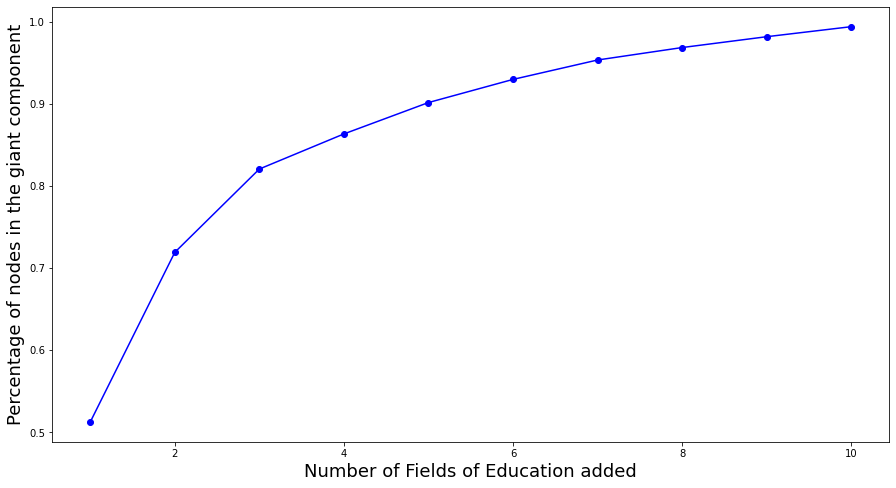

In [20]:
fig = plt.figure(figsize=(15,8))
plt.plot([i+1 for i in range(len(giant_perc_add))], giant_perc_add, 'bo-')
plt.xlabel('Number of Fields of Education added', size=18)
plt.ylabel('Percentage of nodes in the giant component', size=18)
plt.show()

In [21]:
adding_fields_df = pd.DataFrame({'percentage' : giant_perc_add}, index=added_fields).sort_values('percentage')
print('Adding the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:')
display(adding_fields_df.head(10))

Adding the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:


,percentage
Arts and humanities,0.512502
"Business, administration and law",0.719039
"Engineering, manufacturing and construction",0.820437
"Social sciences, journalism and information",0.863162
Health and welfare,0.901359
"Natural sciences, mathematics and statistics",0.929514
Services,0.953140
Information and Communication Technologies (ICTs),0.968301
Education,0.981492
"Agriculture, forestry, fisheries and veterinary",0.993700


In [22]:
removed_fields = []
remaining_fields = list(mobility_df['Field of Education'].unique())
giant_perc_rem =[]
while len(remaining_fields):
    d = {}
    for field in remaining_fields:
        temp_df = mobility_df.loc[~mobility_df['Field of Education'].isin(removed_fields+[field])]
        temp_serie = temp_df.groupby(['SendId', 'RecId']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        d[field] = ns.fraction_in_giant(temp_adj)
    new_field = min(d, key=d.get)
    removed_fields.append(new_field)
    remaining_fields.remove(new_field)
    giant_perc_rem.append(d[new_field])

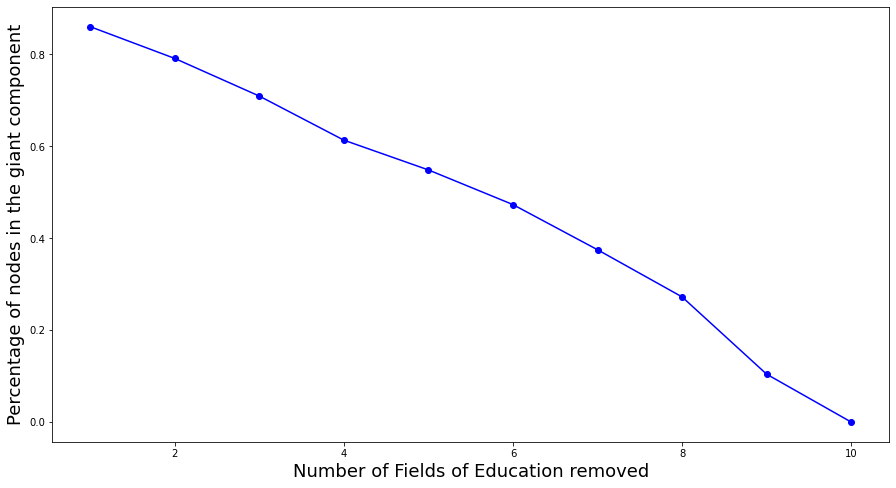

In [23]:
fig = plt.figure(figsize=(15,8))
plt.plot([i+1 for i in range(len(giant_perc_rem))], giant_perc_rem, 'bo-')
plt.xlabel('Number of Fields of Education removed', size=18)
plt.ylabel('Percentage of nodes in the giant component', size=18)
plt.show()

In [24]:
removing_fields_df = pd.DataFrame({'percentage' : giant_perc_rem}, index=removed_fields).sort_values('percentage', ascending=False)
print('Removing the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:')
display(removing_fields_df.head(10))

Removing the edges from the following fields iteratively, we get the following percentages of nodes in the giant component:


,percentage
Arts and humanities,0.860406
"Engineering, manufacturing and construction",0.791297
"Business, administration and law",0.709392
"Social sciences, journalism and information",0.613507
Services,0.548730
Information and Communication Technologies (ICTs),0.473322
"Natural sciences, mathematics and statistics",0.375074
Education,0.272495
Health and welfare,0.104351
"Agriculture, forestry, fisheries and veterinary",0.000197
